# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [432]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [433]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [434]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [435]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [436]:
class buildTrain():
    def __init__(self, X, y, perc=(0.7,0.15,0.15), std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        if not isinstance(perc, tuple) or np.abs(1-sum(perc))>1e-7:
            raise Exception('Invalid value for perc', perc)
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        n_train = int(perc[0]*n_data)
        n_valid = int(perc[1]*n_data)
        train_mask = perm < perc[0]
        valid_mask = ~ train_mask.copy()
        valid_mask[~train_mask] = perm[~train_mask] < perc[0] + perc[1]
        test_mask = ~ np.logical_or(train_mask, valid_mask)
        print(n_data, sum(train_mask), sum(valid_mask), sum(test_mask))
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        test_data = X[test_mask]
        test_target = y[test_mask] 
        assert (len(train_data)+len(valid_data)+len(test_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            test_data = (test_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            test_data = my_pca.transform(test_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        self.Xts = test_data
        self.yts = test_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_test(self):
        return self.Xts, self.yts
    
    def get_size(self):
        return self.Xt.shape[0], self.Xv.shape[0], self.Xts.shape[0]

In [437]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [438]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [439]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [440]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [441]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [442]:
class interface():
    def __init__(self, seed = None, build_seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
            
    def train(self, X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        data = buildTrain(X, y, percentage, std, pca, seed=self.build_seed)
        self._check_balanced(y, threshold_unbalanced, args)
        self._train(X, y, data, epochs, args)
        if self.unbalanced:
            self._unbal_output(data.get_valid())
        self.train_param = (X, y, percentage, std, pca, epochs, args)
        self.data = data
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat] 
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat: 1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%class_weight[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, data, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y, fill_up=False):
        obj = self.obj
        assert y.shape[0] == X.shape[0]
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert to_be_predicted.shape[0] != 0
        prediction = obj.predict(to_be_predicted)
        if fill_up:
            y[mask] = prediction
        return prediction
    
    def get_test(self):
        return self.data.get_test()

In [443]:
def train_perc_warm(perc, data, X, y, epochs, eta0, f_eta, v):
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores

In [444]:
def train_perc_cold(perc, data, X, y, max_iter):
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore

In [445]:
class perc(interface):
    
    def _train(self, X, y, data, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, data, X, y, epochs, args['eta0'], f_eta, True)
        param_cold = (perc_, data, X, y, max_iter)
        
        #perform analysis
        if warm_start:
            tscores, vscores = train_perc_warm(*param_warm)
        else:
            tscores, vscores = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores
    
    def __str__(self):
        return 'Perceptron interface'

In [446]:
def train_MLP(ml_perc, data, X, y, max_iter= 30, v=True):
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores

In [447]:
class MLP(interface):
    
    def _train(self, X, y, data, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, data, X, y, epochs, True)
        
        tscores, vscores = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores
    
    def __str__(self):
        return 'MLP interface'

In [448]:
def train_LR(log_reg, data, X, y, max_iter= 30, v=True):

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores

In [449]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, data, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, data, X, y, epochs, True)
        
        tscores, vscores = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores
    def __str__(self):
        return 'Logistic Regression interface'

In [450]:
def test_sup(X, y, *objs):
    assert X.shape[0] == len(y)
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        print(X.shape, y.shape)
        score = obj.obj.score(X, y)
        print(score)
        scores[c] = score
        print(scores)
        c += 1
        print(c)
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Data imputation taken seriously
### OS

In [451]:
df_filled = df_clean.copy()

X = df_filled[traffic_columns]
y = df_filled['OS_clean']
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

1452 1004 217 231
run=1 tscore=0.366534 vscore=0.40553
run=2 tscore=0.36753 vscore=0.40553
run=3 tscore=0.36753 vscore=0.40553
run=4 tscore=0.36753 vscore=0.40553
run=5 tscore=0.36753 vscore=0.40553
run=6 tscore=0.366534 vscore=0.40553
run=7 tscore=0.36753 vscore=0.40553
run=8 tscore=0.36753 vscore=0.40553
run=9 tscore=0.36753 vscore=0.40553
run=10 tscore=0.36753 vscore=0.40553
run=11 tscore=0.36753 vscore=0.40553
run=12 tscore=0.36753 vscore=0.40553
run=13 tscore=0.36753 vscore=0.40553
run=14 tscore=0.36753 vscore=0.40553
run=15 tscore=0.36753 vscore=0.40553
run=16 tscore=0.36753 vscore=0.40553
run=17 tscore=0.36753 vscore=0.40553
run=18 tscore=0.36753 vscore=0.40553
run=19 tscore=0.36753 vscore=0.40553
run=20 tscore=0.36753 vscore=0.40553
run=21 tscore=0.36753 vscore=0.40553
run=22 tscore=0.36753 vscore=0.40553
run=23 tscore=0.36753 vscore=0.40553
run=24 tscore=0.36753 vscore=0.410138
run=25 tscore=0.369522 vscore=0.410138
run=26 tscore=0.369522 vscore=0.414747
run=27 tscore=0.369522

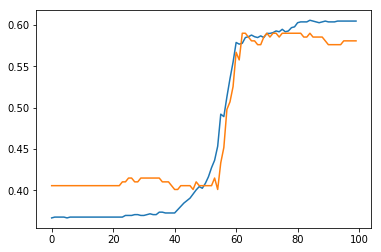

In [452]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

1452 1004 217 231
epoch=0 loss=0.8832857293186401 tscore=0.6165338645418327 vscore=0.5898617511520737
epoch=1 loss=0.7495404073508319 tscore=0.6105577689243028 vscore=0.5852534562211982
epoch=2 loss=0.7675696718069235 tscore=0.6444223107569721 vscore=0.6405529953917051
epoch=3 loss=0.7321316519543257 tscore=0.6205179282868526 vscore=0.5990783410138248
epoch=4 loss=0.7108590891655031 tscore=0.6852589641434262 vscore=0.6774193548387096
epoch=5 loss=0.7120464942454815 tscore=0.6284860557768924 vscore=0.6175115207373272
epoch=6 loss=0.701019559157248 tscore=0.6404382470119522 vscore=0.631336405529954


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=7 loss=0.6947629988104134 tscore=0.6743027888446215 vscore=0.6774193548387096
epoch=8 loss=0.6866469980665064 tscore=0.7151394422310757 vscore=0.7004608294930875
epoch=9 loss=0.6732674292448274 tscore=0.6454183266932271 vscore=0.6359447004608295
epoch=10 loss=0.6723087291714355 tscore=0.6643426294820717 vscore=0.6543778801843319
epoch=11 loss=0.6603240371245976 tscore=0.7679282868525896 vscore=0.7603686635944701
epoch=12 loss=0.6781651824098722 tscore=0.6424302788844621 vscore=0.6405529953917051
epoch=13 loss=0.6691259819230907 tscore=0.6553784860557769 vscore=0.6451612903225806
epoch=14 loss=0.6730638921191014 tscore=0.7828685258964143 vscore=0.783410138248848
epoch=15 loss=0.6572876431793208 tscore=0.7061752988047809 vscore=0.6912442396313364
epoch=16 loss=0.6472322731816698 tscore=0.6424302788844621 vscore=0.6497695852534562
epoch=17 loss=0.6630155541278525 tscore=0.7300796812749004 vscore=0.7373271889400922
epoch=18 loss=0.6402870481721931 tscore=0.6862549800796812 vscore=0.6

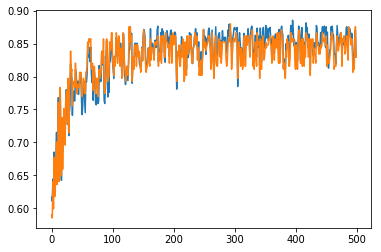

In [453]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

1452 1004 217 231
epoch=0 tscore=0.6065737051792829 vscore=0.5852534562211982
epoch=1 tscore=0.6065737051792829 vscore=0.5852534562211982
epoch=2 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=3 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=4 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=5 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=6 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=7 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=8 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=9 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=10 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=11 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=12 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=13 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=14 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=15 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=16 tscore=

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=17 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=18 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=19 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=20 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=21 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=22 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=23 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=24 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=25 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=26 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=27 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=28 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=29 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=30 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=31 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=32 tscore=0.6245019920318725 vscore=0.6221198156682027
epoch=33 tscore=0.624501

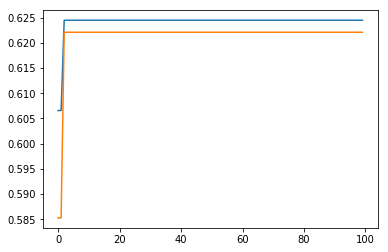

In [454]:
my_lr.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(231, 13) (231,)
0.5324675324675324
[0.53246753 0.         0.        ]
1
(231, 13) (231,)
0.8225108225108225
[0.53246753 0.82251082 0.        ]
2
(231, 13) (231,)
0.5194805194805194
[0.53246753 0.82251082 0.51948052]
3


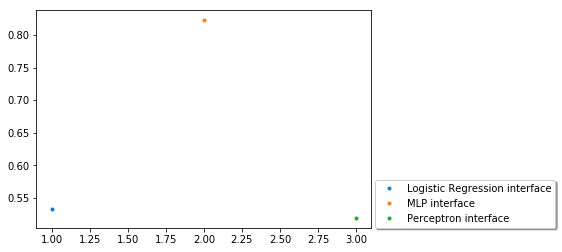

best is MLP interface with score 0.82


In [455]:
test_sup(*my_MLP.get_test(), my_lr, my_MLP, my_perc)

Therefore we use this MLP to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [456]:
os_missing = my_MLP.predict(X,y, fill_up=True)

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Urbanization

In [457]:
X = df_filled[traffic_columns]
df_filled['Urban'] = df_filled['Urban'].map(lambda x: int(x), na_action = 'ignore')
y = df_filled['Urban']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

1654 1137 255 262
run=1 tscore=0.335972 vscore=0.32549
run=2 tscore=0.335972 vscore=0.32549
run=3 tscore=0.335972 vscore=0.32549
run=4 tscore=0.336851 vscore=0.32549
run=5 tscore=0.336851 vscore=0.32549
run=6 tscore=0.335972 vscore=0.32549
run=7 tscore=0.336851 vscore=0.32549
run=8 tscore=0.336851 vscore=0.32549
run=9 tscore=0.336851 vscore=0.32549
run=10 tscore=0.337731 vscore=0.32549
run=11 tscore=0.337731 vscore=0.32549
run=12 tscore=0.337731 vscore=0.32549
run=13 tscore=0.33861 vscore=0.32549
run=14 tscore=0.33861 vscore=0.32549
run=15 tscore=0.33861 vscore=0.32549
run=16 tscore=0.33861 vscore=0.32549
run=17 tscore=0.33861 vscore=0.32549
run=18 tscore=0.337731 vscore=0.32549
run=19 tscore=0.337731 vscore=0.32549
run=20 tscore=0.337731 vscore=0.32549
run=21 tscore=0.337731 vscore=0.321569
run=22 tscore=0.337731 vscore=0.321569
run=23 tscore=0.33861 vscore=0.321569
run=24 tscore=0.337731 vscore=0.321569
run=25 tscore=0.337731 vscore=0.32549
run=26 tscore=0.336851 vscore=0.32549
run=2

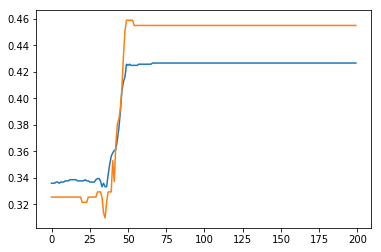

In [458]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

1654 1137 255 262
epoch=0 loss=1.1388561402064168 tscore=0.3254177660510114 vscore=0.32941176470588235
epoch=1 loss=1.129611403196347 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=2 loss=1.1221763604039303 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=3 loss=1.1161255771344782 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=4 loss=1.1112807545489278 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=5 loss=1.1071973172368235 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=6 loss=1.1039714665865776 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=7 loss=1.1012979054668546 tscore=0.42656112576956906 vscore=0.4549019607843137


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=8 loss=1.0990477923642585 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=9 loss=1.0973390164968386 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=10 loss=1.09581602890517 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=11 loss=1.0945314937503479 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=12 loss=1.093327346540357 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=13 loss=1.0924357605387216 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=14 loss=1.091637634224572 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=15 loss=1.0908057064253434 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=16 loss=1.0900874559683187 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=17 loss=1.089414246874098 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=18 loss=1.0888159345258999 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=19 loss=1.0882189886146851 tscore=0.42656112576956906 v

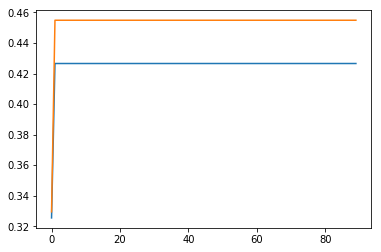

In [459]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

1654 1137 255 262
epoch=0 tscore=0.42656112576956906 vscore=0.4549019607843137
epoch=1 tscore=0.4212840809146878 vscore=0.47058823529411764
epoch=2 tscore=0.43007915567282323 vscore=0.4627450980392157
epoch=3 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=4 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=5 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=6 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=7 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=8 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=9 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=10 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=11 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=12 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=13 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=14 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=15 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=16 tsco

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=24 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=25 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=26 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=27 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=28 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=29 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=30 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=31 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=32 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=33 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=34 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=35 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=36 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=37 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=38 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=39 tscore=0.4309586631486368 vscore=0.4627450980392157
epoch=40 tscore=0.43095

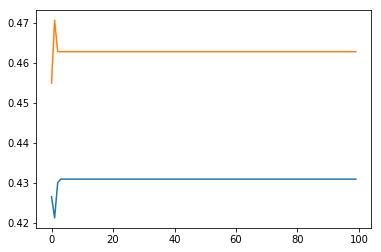

In [460]:
my_lr.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(262, 13) (262,)
0.4389312977099237
[0.4389313 0.        0.       ]
1
(262, 13) (262,)
0.45038167938931295
[0.4389313  0.45038168 0.        ]
2
(262, 13) (262,)
0.45038167938931295
[0.4389313  0.45038168 0.45038168]
3


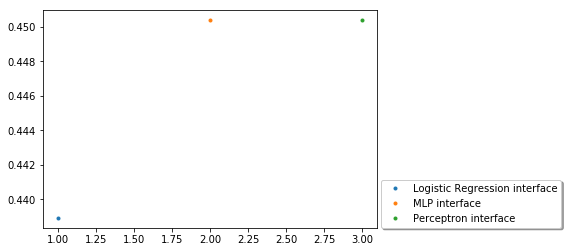

best is MLP interface with score 0.45


In [461]:
test_sup(*my_MLP.get_test(), my_lr, my_MLP, my_perc)

In [462]:
urbanization = my_lr.predict(X,y, fill_up=True)

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Numeric Age

In [463]:
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df_filled["NumericAge"] = df_filled["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df_filled[traffic_columns]
y = df_filled['NumericAge']
build_seed = 456222
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

1880 1307 285 288
Weights used: {2.0: 208.89, 1.0: 1.55, 0.0: 2.84}
run=1 tscore=0.648049 vscore=0.6
run=2 tscore=0.648049 vscore=0.6
run=3 tscore=0.648049 vscore=0.6
run=4 tscore=0.646519 vscore=0.6
run=5 tscore=0.649579 vscore=0.589474
run=6 tscore=0.648049 vscore=0.589474
run=7 tscore=0.648814 vscore=0.589474
run=8 tscore=0.648814 vscore=0.589474
run=9 tscore=0.649579 vscore=0.6
run=10 tscore=0.648814 vscore=0.6
run=11 tscore=0.648814 vscore=0.603509
run=12 tscore=0.649579 vscore=0.6
run=13 tscore=0.648049 vscore=0.6
run=14 tscore=0.649579 vscore=0.607018
run=15 tscore=0.648814 vscore=0.607018
run=16 tscore=0.646519 vscore=0.603509
run=17 tscore=0.647284 vscore=0.607018
run=18 tscore=0.645754 vscore=0.607018
run=19 tscore=0.646519 vscore=0.603509
run=20 tscore=0.644223 vscore=0.603509
run=21 tscore=0.643458 vscore=0.603509
run=22 tscore=0.645754 vscore=0.603509
run=23 tscore=0.644989 vscore=0.6
run=24 tscore=0.643458 vscore=0.592982
run=25 tscore=0.644223 vscore=0.589474
run=26 tsco

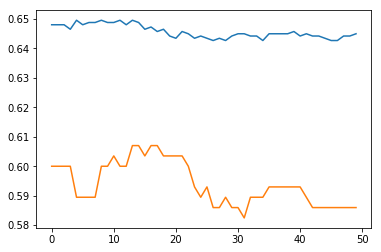

In [464]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight=None)

1880 1307 285 288
epoch=0 loss=0.807371477777275 tscore=0.6472838561591431 vscore=0.6
epoch=1 loss=0.6778907706063428 tscore=0.6472838561591431 vscore=0.6
epoch=2 loss=0.6960129401814067 tscore=0.648814078041316 vscore=0.6035087719298246
epoch=3 loss=0.67631331763764 tscore=0.6541698546289212 vscore=0.6070175438596491
epoch=4 loss=0.672543859061838 tscore=0.6480489671002295 vscore=0.6
epoch=5 loss=0.669702337487172 tscore=0.6480489671002295 vscore=0.6
epoch=6 loss=0.6691233319097804 tscore=0.5554705432287682 vscore=0.5508771929824562
epoch=7 loss=0.6943121409231472 tscore=0.6480489671002295 vscore=0.6
epoch=8 loss=0.6726161705192022 tscore=0.6480489671002295 vscore=0.6


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=9 loss=0.6745267727800957 tscore=0.6273909716908952 vscore=0.5684210526315789
epoch=10 loss=0.6918967104751332 tscore=0.6480489671002295 vscore=0.6
epoch=11 loss=0.6693856659597254 tscore=0.6480489671002295 vscore=0.5929824561403508
epoch=12 loss=0.665885570519515 tscore=0.6480489671002295 vscore=0.6
epoch=13 loss=0.6642739023491268 tscore=0.6480489671002295 vscore=0.6
epoch=14 loss=0.6593350134498989 tscore=0.6495791889824024 vscore=0.6035087719298246
epoch=15 loss=0.6599268638462826 tscore=0.6480489671002295 vscore=0.6
epoch=16 loss=0.6733208742719036 tscore=0.6373374139250191 vscore=0.5964912280701754
epoch=17 loss=0.6691253601563862 tscore=0.6480489671002295 vscore=0.6
epoch=18 loss=0.664153733866062 tscore=0.6518745218056619 vscore=0.6070175438596491
epoch=19 loss=0.6601251918138836 tscore=0.6480489671002295 vscore=0.6
epoch=20 loss=0.6582700221821541 tscore=0.6480489671002295 vscore=0.6
epoch=21 loss=0.6615872358113616 tscore=0.6480489671002295 vscore=0.6
epoch=22 loss=0.66

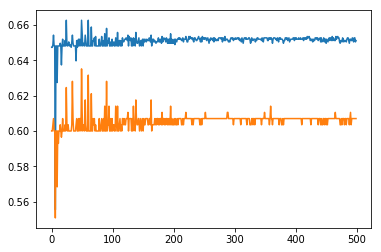

In [465]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.2, tol = 1e-4)

1880 1307 285 288
Weights used: {2.0: 208.89, 1.0: 1.55, 0.0: 2.84}
epoch=0 tscore=0.396327467482785 vscore=0.3824561403508772
epoch=1 tscore=0.4843152257077276 vscore=0.47017543859649125
epoch=2 tscore=0.486610558530987 vscore=0.45263157894736844
epoch=3 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=4 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=5 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=6 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=7 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=8 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=9 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=10 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=11 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=12 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=13 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=14 tscore=0.48584544758990056 vscore=0.45263157894736844
epo

C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)



epoch=34 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=35 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=36 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=37 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=38 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=39 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=40 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=41 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=42 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=43 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=44 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=45 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=46 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=47 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=48 tscore=0.48584544758990056 vscore=0.45263157894736844
epoch=49 tscore=0.48584544758990056 vscore=0.452631578

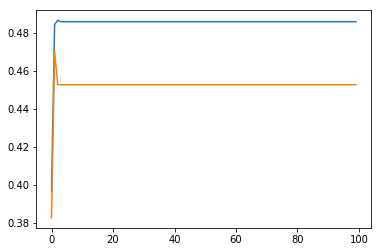

In [466]:
my_lr.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(288, 13) (288,)
0.5173611111111112
[0.51736111 0.         0.        ]
1
(288, 13) (288,)
0.6666666666666666
[0.51736111 0.66666667 0.        ]
2
(288, 13) (288,)
0.6423611111111112
[0.51736111 0.66666667 0.64236111]
3


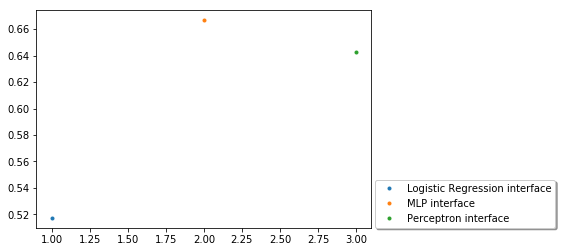

best is MLP interface with score 0.67


In [467]:
test_sup(*my_MLP.get_test(), my_lr, my_MLP, my_perc)

In [468]:
num_age = my_MLP.predict(X,y, fill_up=True)

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Data Allowance

In [469]:
#most between 0 and 0.33, cut out outliers and rescale ?

X = df_filled[traffic_columns]
df_filled['DataAllowance'] = df_filled['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataAllowance']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

1636 1126 251 259
run=1 tscore=0.363233 vscore=0.374502
run=2 tscore=0.365009 vscore=0.370518
run=3 tscore=0.364121 vscore=0.330677
run=4 tscore=0.345471 vscore=0.286853
run=5 tscore=0.345471 vscore=0.278884
run=6 tscore=0.365897 vscore=0.338645
run=7 tscore=0.365897 vscore=0.346614
run=8 tscore=0.366785 vscore=0.358566
run=9 tscore=0.363233 vscore=0.36255
run=10 tscore=0.365009 vscore=0.342629
run=11 tscore=0.364121 vscore=0.36255
run=12 tscore=0.364121 vscore=0.354582
run=13 tscore=0.365009 vscore=0.358566
run=14 tscore=0.365009 vscore=0.346614
run=15 tscore=0.363233 vscore=0.334661
run=16 tscore=0.364121 vscore=0.334661
run=17 tscore=0.366785 vscore=0.354582
run=18 tscore=0.361456 vscore=0.346614
run=19 tscore=0.364121 vscore=0.346614
run=20 tscore=0.363233 vscore=0.338645
run=21 tscore=0.362345 vscore=0.350598
run=22 tscore=0.365897 vscore=0.338645
run=23 tscore=0.361456 vscore=0.338645
run=24 tscore=0.365897 vscore=0.346614
run=25 tscore=0.361456 vscore=0.322709
run=26 tscore=0.36

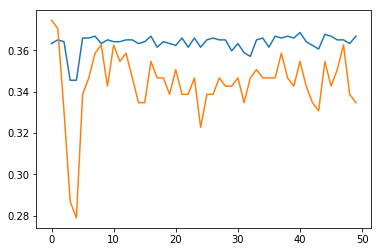

In [470]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

1636 1126 251 259
epoch=0 loss=2.2383624968388003 tscore=0.06127886323268206 vscore=0.06772908366533864
epoch=1 loss=2.21796606312789 tscore=0.0674955595026643 vscore=0.06772908366533864
epoch=2 loss=2.1982087154848022 tscore=0.07726465364120781 vscore=0.07569721115537849
epoch=3 loss=2.179007658470693 tscore=0.11367673179396093 vscore=0.11952191235059761


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=4 loss=2.1602264042938892 tscore=0.21580817051509768 vscore=0.1952191235059761
epoch=5 loss=2.141654052542204 tscore=0.31349911190053287 vscore=0.27091633466135456
epoch=6 loss=2.122968046110643 tscore=0.32948490230905864 vscore=0.28286852589641437
epoch=7 loss=2.1051176512471166 tscore=0.3285968028419183 vscore=0.28286852589641437
epoch=8 loss=2.0871207136161503 tscore=0.34369449378330375 vscore=0.28286852589641437
epoch=9 loss=2.069561221563418 tscore=0.3428063943161634 vscore=0.30278884462151395
epoch=10 loss=2.0523468979431456 tscore=0.35168738898756663 vscore=0.32270916334661354
epoch=11 loss=2.0349580222278982 tscore=0.35968028419182946 vscore=0.33067729083665337
epoch=12 loss=2.0181111070140534 tscore=0.3552397868561279 vscore=0.3386454183266932
epoch=13 loss=2.001463510972635 tscore=0.35346358792184723 vscore=0.3466135458167331
epoch=14 loss=1.985335377847013 tscore=0.3552397868561279 vscore=0.36254980079681276
epoch=15 loss=1.9695998892157716 tscore=0.35346358792184723 v

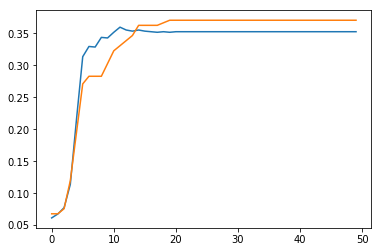

In [471]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)

(259, 13) (259,)
0.3474903474903475
[0.34749035 0.        ]
1
(259, 13) (259,)
0.3281853281853282
[0.34749035 0.32818533]
2


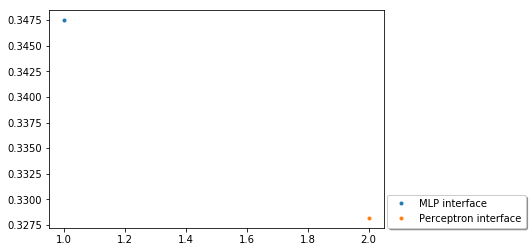

best is MLP interface with score 0.35


In [472]:
test_sup(*my_MLP.get_test(), my_MLP, my_perc)

In [473]:
data_all = my_MLP.predict(X,y, fill_up=True)

C:\Users\guglielmo\Anaconda3\lib\site-packages\ipykernel\__main__.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Monthly Data Traffic

In [474]:
X = df_filled[traffic_columns]
df_filled['MonthlyDataTraffic'] = df_filled['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyDataTraffic']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

In [475]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

1917 1316 297 304
Weights used: {'0.2': 17.75, '0.0': 1.59, '0.1': 3.39, '0.5': 639.0, '0.3': 106.5, '0.4': 174.27, '1.0': 958.5, '0.9': 1917.0, '0.7': 1917.0}


ValueError: Class label 0.7 not present.

In [ ]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

1917 1316 297 304
epoch=0 loss=1.2721702301739526 tscore=0.6238601823708206 vscore=0.67003367003367
epoch=1 loss=0.9478191047512323 tscore=0.6246200607902735 vscore=0.6734006734006734
epoch=2 loss=0.9018776141774245 tscore=0.6246200607902735 vscore=0.6632996632996633
epoch=3 loss=0.8777136164161643 tscore=0.6246200607902735 vscore=0.6734006734006734
epoch=4 loss=0.8690873260900208 tscore=0.6231003039513677 vscore=0.6666666666666666
epoch=5 loss=0.8673941638878023 tscore=0.6291793313069909 vscore=0.6734006734006734


C:\Users\guglielmo\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=6 loss=0.8610961666914014 tscore=0.628419452887538 vscore=0.6801346801346801
epoch=7 loss=0.853497963973305 tscore=0.6390577507598785 vscore=0.6801346801346801
epoch=8 loss=0.854839934715213 tscore=0.6352583586626139 vscore=0.6666666666666666
epoch=9 loss=0.8453416679933262 tscore=0.628419452887538 vscore=0.6734006734006734
epoch=10 loss=0.8591789924787715 tscore=0.6405775075987842 vscore=0.6734006734006734
epoch=11 loss=0.849542229679893 tscore=0.6314589665653495 vscore=0.6801346801346801
epoch=12 loss=0.8488907586639344 tscore=0.6534954407294833 vscore=0.6835016835016835
epoch=13 loss=0.8521252183775185 tscore=0.6458966565349544 vscore=0.6767676767676768
epoch=14 loss=0.8348050328459945 tscore=0.6428571428571429 vscore=0.6767676767676768
epoch=15 loss=0.8357672629027297 tscore=0.6443768996960486 vscore=0.6767676767676768
epoch=16 loss=0.8570697165458112 tscore=0.6550151975683891 vscore=0.6801346801346801
epoch=17 loss=0.8299139418359671 tscore=0.6580547112462006 vscore=0.673400

In [ ]:
test_sup(*my_MLP.get_test(), my_MLP, my_perc)

In [ ]:
data_traffic = my_MLP.predict(X,y, fill_up=True)

# Data ARPU

In [ ]:
X = df_filled[traffic_columns]
df_filled['DataArpu'] = df_filled['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['DataArpu']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

In [ ]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

In [ ]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

In [ ]:
test_sup(*my_MLP.get_test(), my_MLP, my_perc)

In [ ]:
data_arpu = my_MLP.predict(X,y, fill_up=True)

# Monthly Voice Traffic Count

In [ ]:
X = df_filled[traffic_columns]
df_filled['MonthlyVoiceTrafficCount'] = df_filled['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
y = df_filled['MonthlyVoiceTrafficCount']
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

In [ ]:
my_perc.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

In [ ]:
my_MLP.train(X, y, percentage=(0.70,0.15,0.15), std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

In [ ]:
test_sup(*my_MLP.get_test(), my_MLP, my_perc)

In [ ]:
voice_traffic_c = my_perc.predict(X,y, fill_up=True)

In [ ]:
df_good = df_filled.copy()
col_to_del = ['CustomerAge', 'DevicePrice', 'Province', 'Region', 'ZipCode', 'DeviceOperatingSystem']
df_good.drop(col_to_del, axis=1, inplace=True)
df_good['MonthlySmsTrafficCount'][df_good['MonthlySmsTrafficCount'].isnull()] = df_good['MonthlySmsTrafficCount'].mean()
df_good.info()